In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/Dao-AILab/flash-attention
%cd flash-attention
!git checkout ad113948a6c3864fbe48156a9857e97a38ce758c

Cloning into 'flash-attention'...
remote: Enumerating objects: 8903, done.
remote: Counting objects: 100% (424/424), done.
remote: Compressing objects: 100% (181/181), done.
remote: Total 8903 (delta 346), reused 247 (delta 243), pack-reused 8479 (from 3)
Receiving objects: 100% (8903/8903), 8.90 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (6779/6779), done.
/content/flash-attention
Note: switching to 'ad113948a6c3864fbe48156a9857e97a38ce758c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at ad11394 [Docs] 

In [ ]:
!git status

HEAD detached at ad11394
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   flash_attn/flash_attention.py

no changes added to commit (use "git add" and/or "git commit -a")


Make the change in the code by adding self.batch_first = batch_first

In [ ]:
! pip install .

Processing /content/flash-attention
  Preparing metadata (setup.py) ... done
  Created wheel for flash_attn: filename=flash_attn-1.0.4-cp310-cp310-linux_x86_64.whl size=72799748 sha256=8f7e9dc876aa15ca8764c2a724e92dcb08c4850e8f6ba59769d8522e4f713912
  Stored in directory: /root/.cache/pip/wheels/98/cf/3b/d132219792be47c1a416734b31d5be638f6a6e282470b490c6
Successfully built flash_attn


In [ ]:
%cd ..

/content


In [1]:
!pip uninstall torch torchtext -y
!pip install torch torchtext
!pip install scgpt
!pip install anndata
!pip install wandb
!pip install 'scanpy[leiden]'
!pip install scvi

Found existing installation: torch 2.1.2
Uninstalling torch-2.1.2:
  Successfully uninstalled torch-2.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 7.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 20.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 15.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 39.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 79.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 54.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 33.5 MB/s eta 0:00:0000:0100:01

In [1]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
#from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
import pandas as pd
import scipy.sparse as sp
from sklearn import preprocessing

sys.path.insert(0, "../")
from scgpt import prepare_data, prepare_dataloader, define_wandb_metrcis, evaluate, eval_testdata, train
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.model import MultiOmicTransformerModel

import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.tokenizer import random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scvi/__init__.py:31: DeprecationWarning: scvi is deprecated, please uninstall scvi via `pip uninstall scvi` and install the new scvi-tools package at github.com/YosefLab/scvi-tools
  warnings.warn(deprecation_msg, DeprecationWarning)
/opt/conda/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [2]:
# import copy
# import gc
# import json
# import os
# from pathlib import Path
# import sys
# import time
# import traceback
# from typing import List, Tuple, Dict, Union, Optional
# import warnings

# import torch
# from anndata import AnnData
# import scanpy as sc
# import scvi
# import numpy as np
# import wandb
# from scipy.sparse import issparse
# import matplotlib.pyplot as plt
# from torch import nn
# from torch.nn import functional as F
# from torch.utils.data import Dataset, DataLoader
# from sklearn.model_selection import train_test_split
# from torchtext.vocab import Vocab
# from torchtext._torchtext import (
#     Vocab as VocabPybind,
# )

# from scgpt.tokenizer.gene_tokenizer import GeneVocab

# sys.path.append("../")
# import scgpt as scg
# from scgpt.model import TransformerModel, AdversarialDiscriminator
# from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
# from scgpt.loss import (
#     masked_mse_loss,
#     masked_relative_error,
#     criterion_neg_log_bernoulli
# )
# from scgpt.preprocess import Preprocessor
# from scgpt import SubsetsBatchSampler
# from scgpt.utils import set_seed, category_str2int, eval_scib_metrics


# # from functions_group import DistanceLoss

# sc.set_figure_params(figsize=(4, 4))
# os.environ["KMP_WARNINGS"] = "off"

# def masked_ce_loss(
#     input: torch.Tensor, target: torch.Tensor, mask: torch.Tensor
# ) -> torch.Tensor:
#     mask = mask.float()
#     loss = F.cross_entropy(input * mask, target * mask, reduction="none")
#     return loss.sum() / mask.sum()

In [3]:
import pandas as pd

In [4]:
hyperparameter_defaults = dict(
    task = 'multiomic',
    seed=42,
    dataset_name="BMMC", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="./scGPT_human/", # Path to pre-trained model
    freeze = False, #freeze
    GEP=True, # Gene expression modelling
    GEPC=True, # Gene expression modelling for cell objective
    CLS=False,
    ESC=False,
    DAR = True, # DAR objective weight for batch correction
    DSBN = False,  # Domain-spec batchnorm,
    mask_ratio=0.4, # Default mask ratio
    explicit_zero_prob = False,  # whether explicit bernoulli for zeros
    ecs_thres=0,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    use_batch_labels = True,
    use_mod = True,
    per_seq_batch_sample = False,
    epochs=25, # Default number of epochs for fine-tuning
    input_layer_key = "X_binned", # Default expression value binning in data pre-processing
    n_bins=51, # Default number of bins for value binning in data pre-processing
    n_hvg = 1200,  # Default number of highly variable genes
    n_hvp = 4000,
    max_seq_len = 4001, # # Default n_hvg+1
    lr=1e-3, # Default learning rate for fine-tuning
    batch_size=16, # Default batch size for fine-tuning
    layer_size=512,
    nlayers=4,
    nhead=8, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.95,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100, # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # Default setting: Automatic Mixed Precision
    pad_token = "<pad>",
    mask_value = -1,
    pad_value = -2,
    include_zero_gene = False,
)


run = wandb.init(
    config=hyperparameter_defaults,
    project="scGPT",
    reinit=True,
    settings=wandb.Settings(start_method="fork"),
)
config = wandb.config
print(config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nischal-gupta (nischal-gupta-strand-life-sciences). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


{'task': 'multiomic', 'seed': 42, 'dataset_name': 'BMMC', 'do_train': True, 'load_model': './scGPT_human/', 'freeze': False, 'GEP': True, 'GEPC': True, 'CLS': False, 'ESC': False, 'DAR': True, 'DSBN': False, 'mask_ratio': 0.4, 'explicit_zero_prob': False, 'ecs_thres': 0, 'dab_weight': 1.0, 'use_batch_labels': True, 'use_mod': True, 'per_seq_batch_sample': False, 'epochs': 25, 'input_layer_key': 'X_binned', 'n_bins': 51, 'n_hvg': 1200, 'n_hvp': 4000, 'max_seq_len': 4001, 'lr': 0.001, 'batch_size': 16, 'layer_size': 512, 'nlayers': 4, 'nhead': 8, 'dropout': 0.2, 'schedule_ratio': 0.95, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'pad_token': '<pad>', 'mask_value': -1, 'pad_value': -2, 'include_zero_gene': False}


In [5]:
2d0573c5efed8dec993a10530b31f3af649ff935 -- api key

SyntaxError: invalid decimal literal (889321086.py, line 1)

In [7]:
special_tokens = [config.pad_token, "<cls>", "<eoc>"]
dataset_name = config.dataset_name
save_dir = Path(f"/content/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

save to /content/dev_BMMC-Jan15-07-46


In [8]:
if dataset_name == 'BMMC':
    adata = sc.read('/scGPT_human/BMMC_processed.h5ad')
    # subset to first 3 donors with B, Mono and T cell subtypes
    adata = adata[adata.obs.DonorID.isin([10886, 11466, 12710]) & adata.obs.cell_type.isin(np.unique(adata.obs.cell_type.values)[:17])]
    adata.obs["celltype"] = adata.obs["cell_type"].astype(str).astype('category')
    adata.var["gene_name"] = adata.var.index.tolist()
    le = preprocessing.LabelEncoder()
    encoded_batch = le.fit_transform(adata.obs['batch'].values)
    adata.obs["batch_id"] =  encoded_batch
    adata.obs["str_batch"] = adata.obs["batch_id"].astype('category')
    adata_protein = adata[:, adata.var.feature_types.isin(['ADT'])].copy()
    adata_protein.var.index = ['p_' + i for i in adata_protein.var.index]
    adata = adata[:, adata.var.feature_types.isin(['GEX'])].copy()
    data_is_raw = False

In [9]:
adata.obs

,GEX_n_genes_by_counts,GEX_pct_counts_mt,GEX_size_factors,GEX_phase,ADT_n_antibodies_by_counts,ADT_total_counts,ADT_iso_count,cell_type,batch,ADT_pseudotime_order,...,DonorBloodType,DonorRace,Ethnicity,DonorGender,QCMeds,DonorSmoker,is_train,celltype,batch_id,str_batch
TCTTGCGGTCATTGCA-1-s1d2,3052,11.130034,1.576498,G2M,135,9587.0,14.0,CD4+ T CD314+ CD45RA+,s1d2,NaN,...,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD4+ T CD314+ CD45RA+,0,0
CGGGCATCACGTCATA-1-s1d2,1869,4.807974,0.835774,G2M,119,4453.0,10.0,CD4+ T activated integrinB7+,s1d2,NaN,...,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD4+ T activated integrinB7+,0,0
GGGTTTATCTCTATGT-1-s1d2,2057,3.280318,0.904262,G2M,126,3400.0,6.0,CD14+ Mono,s1d2,NaN,...,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD14+ Mono,0,0
TACCGGGGTGACTATC-1-s1d2,2043,4.956684,0.887821,G2M,118,5229.0,9.0,CD4+ T naive,s1d2,NaN,...,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD4+ T naive,0,0
ACGATCAGTACGAGTG-1-s1d2,2374,10.282712,1.068720,G2M,129,9417.0,11.0,CD4+ T activated,s1d2,NaN,...,B+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD4+ T activated,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CAACGGCTCACTGATG-1-s3d7,2003,5.744431,1.437091,G2M,121,1405.0,8.0,CD14+ Mono,s3d7,NaN,...,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD14+ Mono,2,2
GTGTAACCATTAAGCC-1-s3d7,1879,7.053232,1.254860,G2M,109,570.0,6.0,CD14+ Mono,s3d7,NaN,...,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD14+ Mono,2,2
CAGCCAGCAACGCATT-1-s3d7,1640,6.559514,1.068252,G2M,111,574.0,5.0,CD14+ Mono,s3d7,NaN,...,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD14+ Mono,2,2
ATCACAGTCGCCAACG-1-s3d7,822,7.060850,0.409965,G1,120,915.0,9.0,CD14+ Mono,s3d7,NaN,...,A+,Asian,NOT HISPANIC OR LATINO,Female,True,Nonsmoker,train,CD14+ Mono,2,2


In [10]:
adata.obs["batch"].value_counts()

batch
s3d7    7429
s1d2    2883
s2d4    2266
Name: count, dtype: int64

In [11]:
if config.use_mod:
    gene_rna_df = pd.DataFrame(index = adata.var.index.tolist())
    gene_rna_df['mod'] = 'RNA'
    gene_protein_df = pd.DataFrame(index = adata_protein.var.index.tolist())
    gene_protein_df['mod'] = 'Protein'
    gene_loc_df = pd.concat([gene_rna_df, gene_protein_df])
    gene_loc_df['mod'] = gene_loc_df['mod'].astype('category')

In [12]:
if config.load_model is not None:
    model_dir = Path(config.load_model)
    model_config_file = "./scGPT_human/args.json"
    model_file = "./scGPT_human/best_model.pt"
    vocab_file = "./scGPT_human/vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    old_vocab = vocab
embsize = config.layer_size
nhead = config.nhead
nlayers = config.nlayers
d_hid = config.layer_size


scGPT - INFO - match 12587/13953 genes in vocabulary of size 60697.


In [13]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=1,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=config.n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...


In [14]:
preprocessor_protein = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor=None,
    binning=config.n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_protein(adata_protein, batch_key=None)

scGPT - INFO - Binning data ...


In [15]:
data_combined = np.concatenate([adata.layers["X_binned"], adata_protein.layers["X_binned"]], axis=1)
adata = AnnData(
    X=data_combined,
    obs=adata.obs,
    var=pd.DataFrame(index=adata.var_names.tolist() + adata_protein.var_names.tolist()),
    layers={"X_binned": data_combined,}
)
adata.var["gene_name"] = adata.var.index.tolist()

In [16]:
if config.per_seq_batch_sample:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

In [17]:
all_counts = (
    adata.layers[config.input_layer_key].A
    if issparse(adata.layers[config.input_layer_key])
    else adata.layers[config.input_layer_key]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

In [18]:
if config.use_mod:
    mod_type = np.array([gene_loc_df.loc[g, 'mod'] for g in genes])
    vocab_mod = Vocab(VocabPybind(np.unique(gene_loc_df['mod']).tolist() + special_tokens, None))
    vocab_mod.set_default_index(vocab_mod["<pad>"])
    mod_type = np.array(vocab_mod(list(mod_type)), dtype=int)
    ntokens_mod = len(vocab_mod)

In [19]:
(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)

In [20]:
num_of_non_zero_genes = [
    np.count_nonzero(train_data[i]) for i in range(train_data.shape[0])
]
print(f"max num of non_zero genes: {np.max(num_of_non_zero_genes)}")
print(f"min num of non_zero genes: {np.min(num_of_non_zero_genes)}")
print(f"average num of non_zero genes: {np.mean(num_of_non_zero_genes)}")
print(
    f"99% quantile num of non_zero genes: {np.quantile(num_of_non_zero_genes, 0.99)}"
)
print(f"max original values: {np.max(train_data)}")
print(
    f"average original non_zero values: {np.mean(train_data[np.nonzero(train_data)])}"
)
print(
    f"99% quantile original non_zero values: {np.quantile(train_data[np.nonzero(train_data)], 0.99)}"
)
print(f"num of celltypes: {num_types}")

max num of non_zero genes: 687
min num of non_zero genes: 206
average num of non_zero genes: 342.045406360424
99% quantile num of non_zero genes: 512.0
max original values: 50
average original non_zero values: 25.34548215190573
99% quantile original non_zero values: 49.0
num of celltypes: 17


In [21]:
if config.load_model is None:
    vocab = Vocab(VocabPybind(genes + special_tokens, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)
else:
    pretrained_genes = [g for g in genes + special_tokens if g in old_vocab]
    new_genes = [g for g in genes + special_tokens if g not in old_vocab]
    gene_ids_pretrained = np.array(old_vocab(pretrained_genes), dtype=int)
    # https://discuss.pytorch.org/t/expand-an-existing-embedding-and-linear-layer-nan-loss-value/55670/2
    # Retrieve pretrained weights
    vocab = Vocab(VocabPybind(pretrained_genes + new_genes, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)


In [22]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=config.max_seq_len,
    vocab=vocab,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=config.include_zero_gene,
    mod_type=mod_type if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=config.max_seq_len,
    vocab=vocab,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    append_cls=True,
    include_zero_gene=config.include_zero_gene,
    mod_type=mod_type if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)

scGPT - INFO - train set number of samples: 11320, 
	 feature length: 688
scGPT - INFO - valid set number of samples: 1258, 
	 feature length: 663


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dict = torch.load(model_file)
ntokens = len(vocab)  # size of vocabulary
model = MultiOmicTransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    dropout=config.dropout,
    pad_token=config.pad_token,
    pad_value=config.pad_value,
    do_mvc=config.GEPC,
    do_dab=config.DAR,
    use_batch_labels=config.use_batch_labels,
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config.DSBN,
    n_input_bins=config.n_bins,
    ecs_threshold=config.ecs_thres,
    explicit_zero_prob=config.explicit_zero_prob,
    use_fast_transformer=config.fast_transformer,
    pre_norm=config.pre_norm,
    use_mod=config.use_mod,
    ntokens_mod=ntokens_mod if config.use_mod else None,
    vocab_mod=vocab_mod if config.use_mod else None,
)

with torch.no_grad():
    pretrained_emb_weights = model_dict['encoder.embedding.weight'][gene_ids_pretrained, :]
    model.encoder.embedding.weight.data[:len(pretrained_genes), :] = pretrained_emb_weights
    model.encoder.enc_norm.weight.data = model_dict['encoder.enc_norm.weight']
ntokens = len(vocab)

model.to(device)
wandb.watch(model)
print(model)


MultiOmicTransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(1337, 512, padding_idx=1089)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(3, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (mod_encoder): BatchLabelEncoder(
    (embedding): Embedding(5, 512, padding_idx=2)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x FlashTransformerEncoderLayer(
        (self_attn): FlashMHA(
          (Wqkv): Linear(in_features=512, ou

In [24]:
if config.GEP and config.GEPC:
    criterion_gep_gepc = masked_mse_loss
if config.CLS:
    criterion_cls = nn.CrossEntropyLoss()
if config.DAR:
    criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config.lr, eps=1e-4 if config.amp else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config.schedule_ratio)
scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

random masking at epoch   1, ratio of masked values in train:  0.3988
scGPT - INFO - | epoch   1 | 100/708 batches | lr 0.00100 | ms/batch 38.98 | loss 7694.70 | gep 382.21 |gepc 7311.44 |dar  1.05 |
scGPT - INFO - | epoch   1 | 200/708 batches | lr 0.00100 | ms/batch 31.38 | loss 281.61 | gep 203.75 |gepc 76.86 |dar  1.00 |
scGPT - INFO - | epoch   1 | 300/708 batches | lr 0.00100 | ms/batch 31.56 | loss 279.26 | gep 202.17 |gepc 76.09 |dar  0.99 |
scGPT - INFO - | epoch   1 | 400/708 batches | lr 0.00100 | ms/batch 31.28 | loss 277.89 | gep 202.15 |gepc 74.77 |dar  0.97 |
scGPT - INFO - | epoch   1 | 500/708 batches | lr 0.00100 | ms/batch 31.60 | loss 277.25 | gep 202.23 |gepc 74.02 |dar  1.00 |
scGPT - INFO - | epoch   1 | 600/708 batches | lr 0.00100 | ms/batch 31.61 | loss 227.72 | gep 152.44 |gepc 74.31 |dar  0.97 |
scGPT - INFO - | epoch   1 | 700/708 batches | lr 0.00100 | ms/batch 31.38 | loss 150.56 | gep 80.08 |gepc 69.61 |dar  0.87 |
scGPT - INFO - ------------------------

100%|██████████| 787/787 [00:07<00:00, 102.10it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.560885
ARI_cluster/label          0.243511
ASW_label                  0.666321
ASW_label/batch            0.771004
PCR_batch                  0.099019
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.827919
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

100%|██████████| 787/787 [00:07<00:00, 101.53it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.630818
ARI_cluster/label          0.420425
ASW_label                  0.686427
ASW_label/batch            0.799679
PCR_batch                  0.260647
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.896075
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

100%|██████████| 787/787 [00:07<00:00, 101.79it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.634216
ARI_cluster/label          0.446591
ASW_label                  0.664553
ASW_label/batch            0.803719
PCR_batch                  0.310294
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.876092
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

100%|██████████| 787/787 [00:07<00:00, 101.84it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.614562
ARI_cluster/label          0.341757
ASW_label                  0.656944
ASW_label/batch            0.842158
PCR_batch                  0.349095
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.934677
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

100%|██████████| 787/787 [00:07<00:00, 101.78it/s]


Recompute neighbors on rep X_scGPT instead of None
Cluster for cluster_0.2 with leiden
Cluster for cluster_0.4 with leiden
Cluster for cluster_0.6 with leiden
Cluster for cluster_0.8 with leiden
Cluster for cluster_1.0 with leiden
Cluster for cluster_1.2 with leiden
Cluster for cluster_1.4 with leiden
Cluster for cluster_1.6 with leiden
Cluster for cluster_1.8 with leiden
Cluster for cluster_2.0 with leiden
NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
scGPT - INFO -                                   0
NMI_cluster/label          0.658310
ARI_cluster/label          0.477183
ASW_label                  0.651322
ASW_label/batch            0.852346
PCR_batch                  0.372181
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette       NaN
graph_conn                 0.930458
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                     N

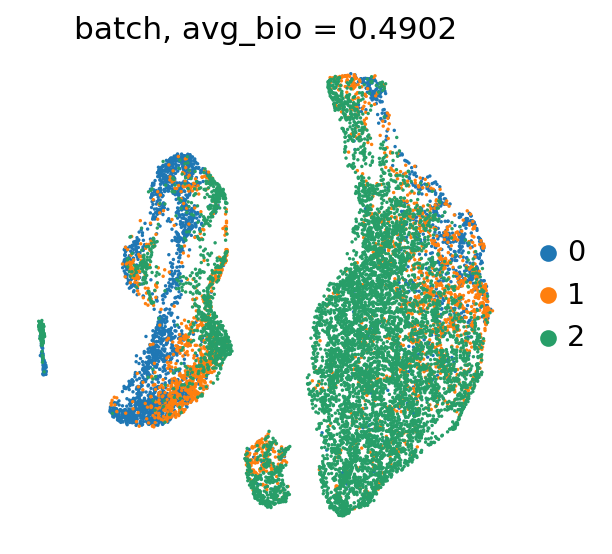

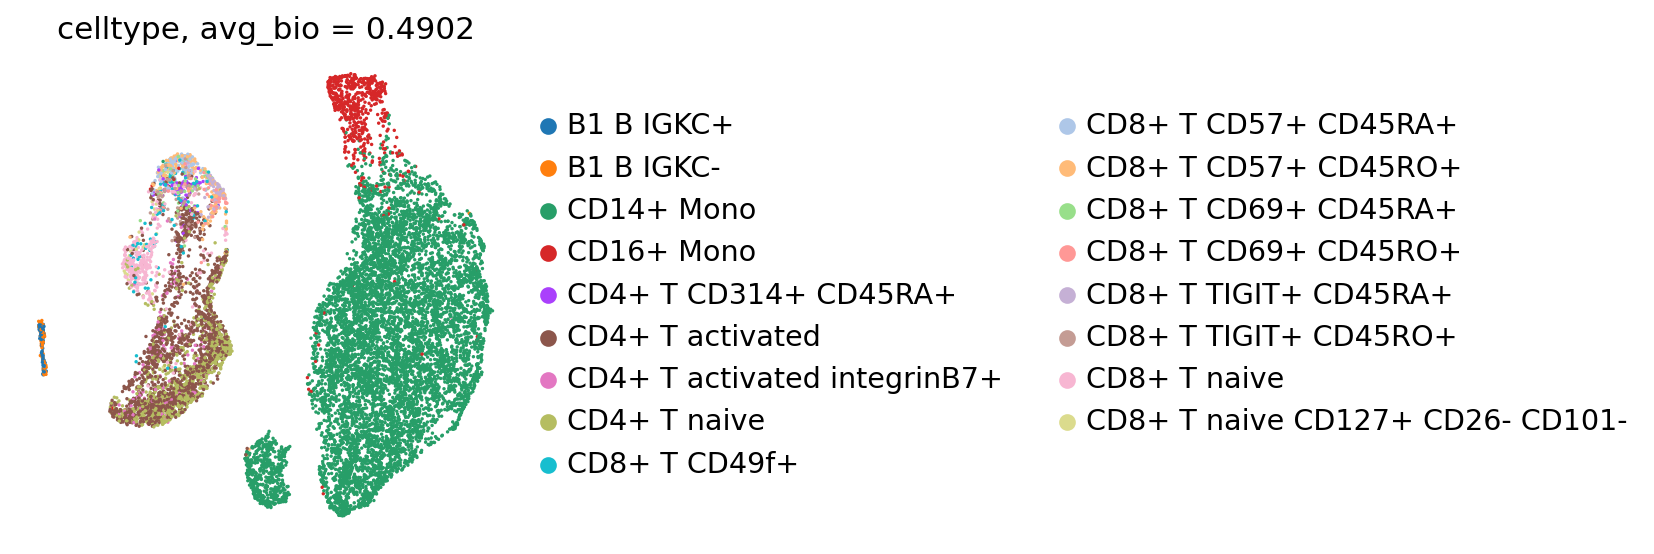

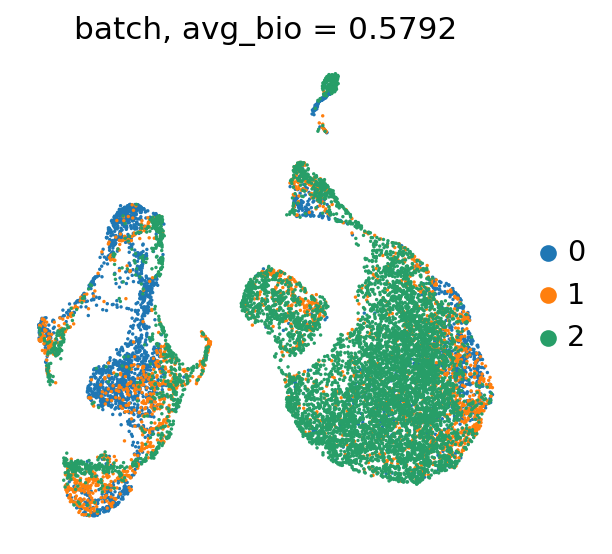

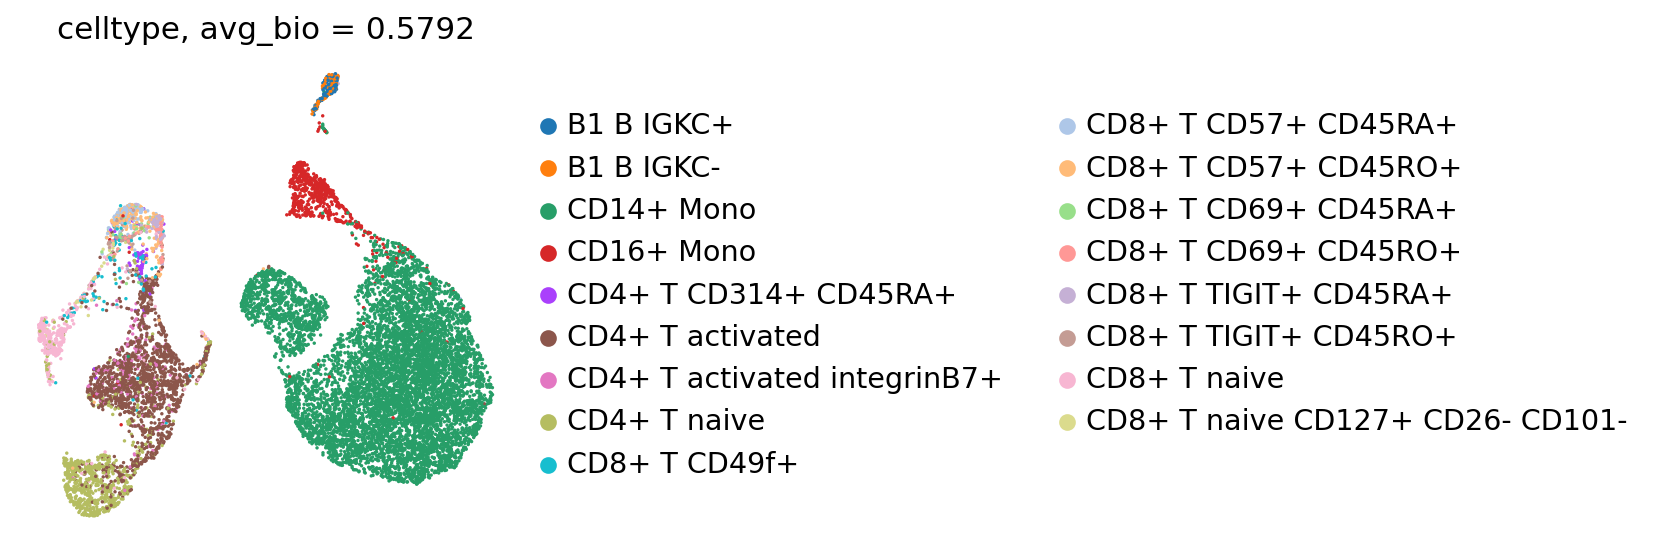

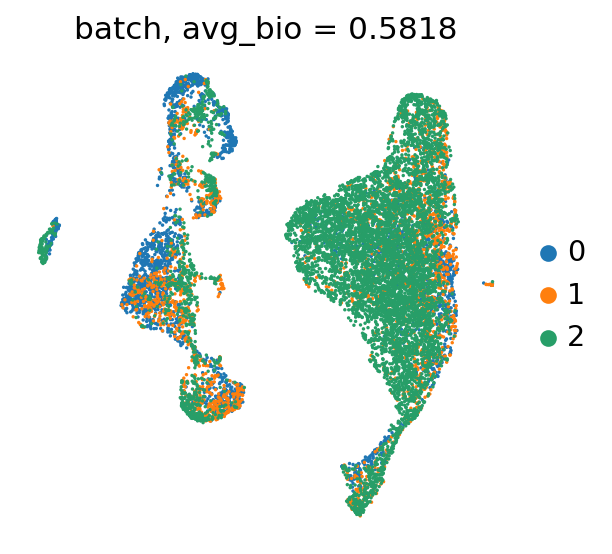

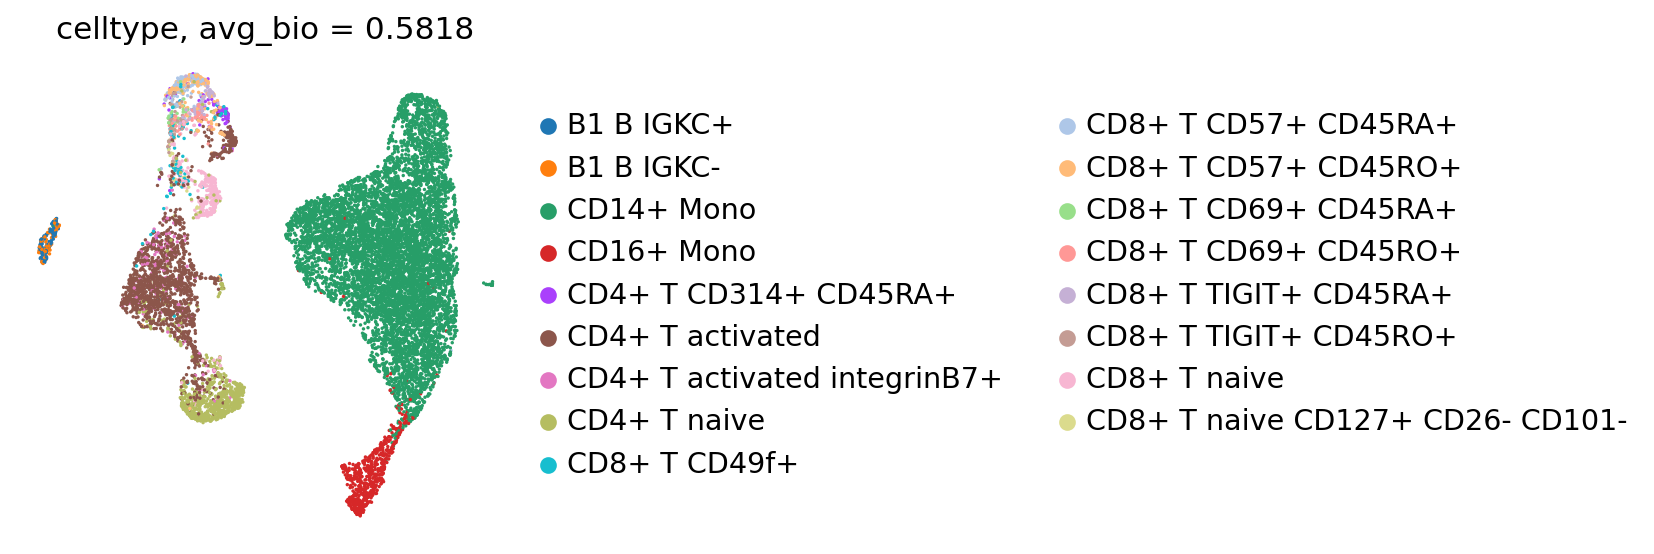

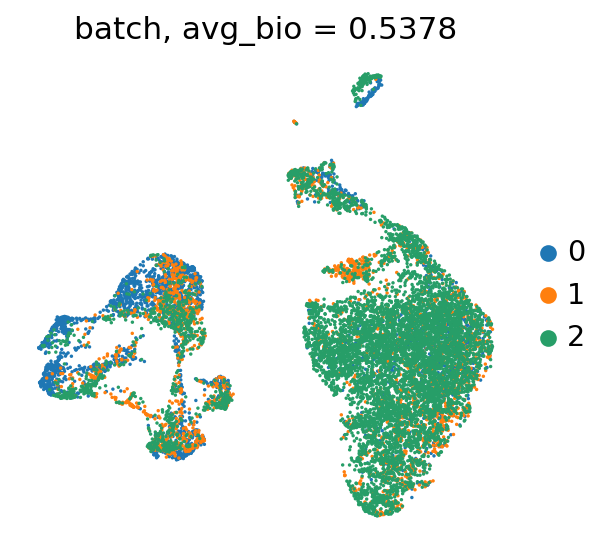

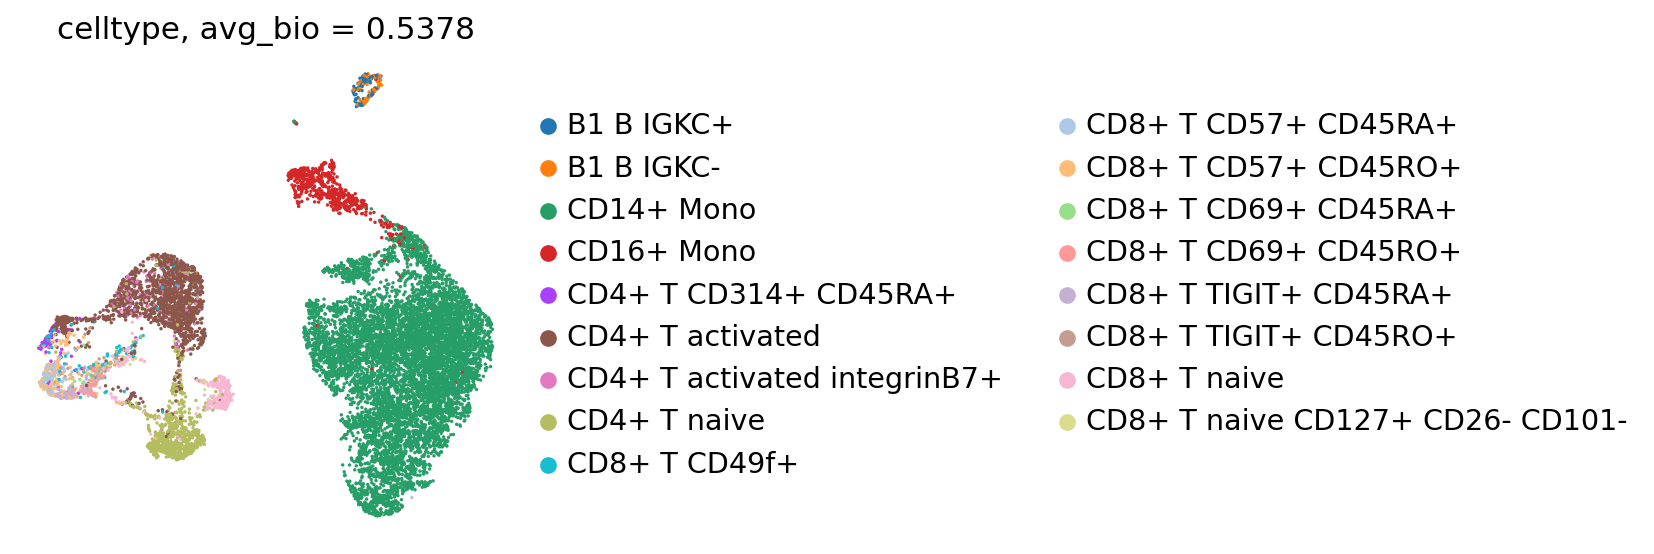

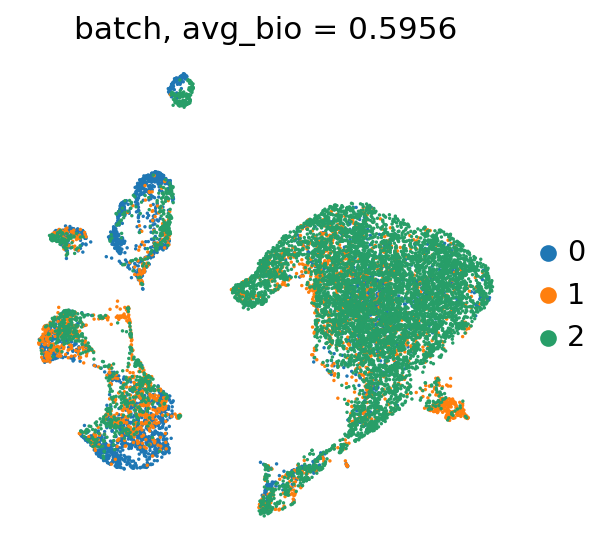

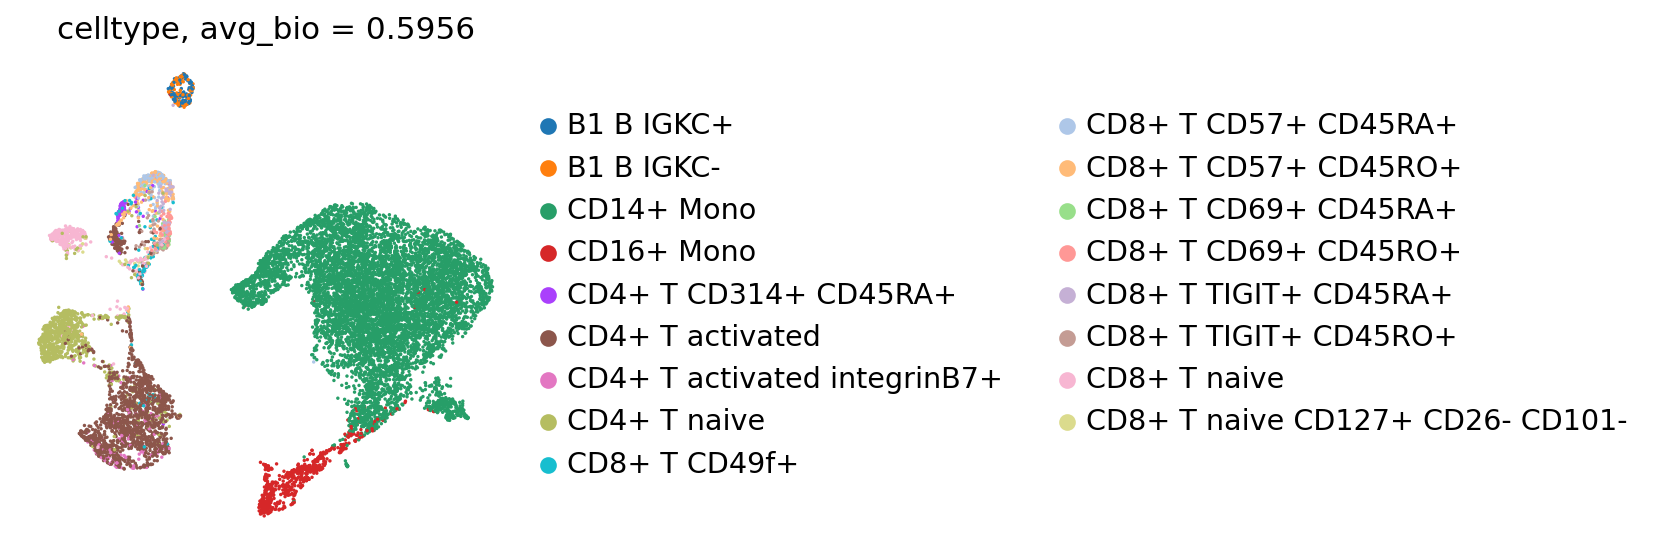

In [25]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
define_wandb_metrcis()

for epoch in range(1, config.epochs + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(
        tokenized_train=tokenized_train,
        tokenized_valid=tokenized_valid,
        train_batch_labels=train_batch_labels,
        valid_batch_labels=valid_batch_labels,
        config=config,
        epoch=epoch,
        sort_seq_batch=config.per_seq_batch_sample)

    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config.batch_size,
        shuffle=True,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config.per_seq_batch_sample
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config.batch_size,
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config.per_seq_batch_sample
    )

    if config.do_train:
        train(
            model=model,
            loader=train_loader,
            vocab=vocab,
            criterion_gep_gepc=criterion_gep_gepc if config.GEP and config.GEPC else None,
            criterion_dab=criterion_dab if config.DAR else None,
            criterion_cls=criterion_cls if config.CLS else None,
            scaler=scaler,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            config=config,
            logger=logger,
            epoch=epoch,
        )
    val_loss = evaluate(
        model=model,
        loader=valid_loader,
        vocab=vocab,
        criterion_gep_gepc=criterion_gep_gepc if config.GEP and config.GEPC else None,
        criterion_dab=criterion_dab if config.DAR else None,
        criterion_cls=criterion_cls if config.CLS else None,
        device=device,
        config=config,
        epoch=epoch
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {val_loss:5.4f} | "
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config.save_eval_interval == 0 or epoch == config.epochs:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            model = best_model,
            adata_t = adata_sorted if config.per_seq_batch_sample else adata,
            gene_ids = gene_ids,
            vocab = vocab,
            config = config,
            logger = logger,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        metrics_to_log["test/batch_umap"] = wandb.Image(
            str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )

        metrics_to_log["test/celltype_umap"] = wandb.Image(
            str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
            caption=f"celltype avg_bio epoch {best_model_epoch}",
        )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        wandb.log(metrics_to_log)
        wandb.log({"avg_bio": results.get("avg_bio", 0.0)})

    scheduler.step()

In [26]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

In [27]:
artifact = wandb.Artifact(f"best_model", type="model")
glob_str = os.path.join(save_dir, "best_model.pt")
artifact.add_file(glob_str)
run.log_artifact(artifact)

run.finish()
wandb.finish()
gc.collect()


avg_bio,▁▇▇▄█
epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
test/ARI_cluster/label,▁▆▇▄█
test/ASW_label,▄█▄▂▁
test/ASW_label/batch,▁▃▄▇█
test/NMI_cluster/label,▁▆▆▅█
test/PCR_batch,▁▅▆▇█
test/avg_bio,▁▇▇▄█
test/best_model_epoch,▁▃▅▇█
test/graph_conn,▁▅▄██
train/dab,▆▇▅▃▂▄▃▂▅▆▆▃▅▄▃▆▃▃▅▆▃▅▅▇█▄▄▂▄▅█▄▇▃▁▅▄▄▃▆


39756